In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
import tempfile
import mlflow
from mlflow.models import infer_signature
from utils import make_data, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

In [2]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

original  label  time  day
0            53.4      0    15    0
1            52.8      0    15    0
2            52.8      0    15    0
3            53.2      0    15    0
4            53.6      0    15    0
...           ...    ...   ...  ...
3995345      45.9      0     5    9
3995346      45.6      0     5    9
3995347      45.8      0     5    9
3995348      45.7      0     5    9
3995349      45.9      0     5    9

[3995350 rows x 4 columns]

# ホールドアウト検証
## 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
---
ラベル付け
* 全体：0, 1, 2, 3, 4, 5 日目
* 訓練ローテ：(訓練、ラベル付与対象)=([0, 1, 2, 3, 4], 5)・・・([5, 0, 1, 2, 3], 4)

In [3]:
test_day=[6, 7, 8, 9]
semi_train_day=[0, 1, 2, 3, 4, 5]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)

In [4]:
best_params={'window': 5, 'nk': 12}

In [5]:
df_list=[]

window=best_params['window']
for i in set(df['day']):
    lag=[] 
    lag.append(make_data(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train_df=pd.concat(df_list)
semi_train_df=semi_train_df.dropna().reset_index(drop=True)
semi_train_df.loc[:, 'knnd']=0
semi_train_df.loc[:, 'knn_label']=0

In [6]:
semi_train_df

original  original_lag1  original_lag2  original_lag3  original_lag4  \
0            53.6           53.2           52.8           52.8           53.4   
1            54.0           53.6           53.2           52.8           52.8   
2            54.7           54.0           53.6           53.2           52.8   
3            55.7           54.7           54.0           53.6           53.2   
4            55.5           55.7           54.7           54.0           53.6   
...           ...            ...            ...            ...            ...   
2393381      45.0           45.4           45.1           44.8           45.4   
2393382      45.2           45.0           45.4           45.1           44.8   
2393383      45.1           45.2           45.0           45.4           45.1   
2393384      45.1           45.1           45.2           45.0           45.4   
2393385      46.0           45.1           45.1           45.2           45.0   

         day  label  knnd  knn_label  
0          0      0     0          0  
1          0      0     0          0  
2          0      0     0          0  
3          0      0     0          0  
4          0      0     0          0  
...      ...    ...   ...        ...  
2393381    5      0     0          0  
2393382    5      0     0          0  
2393383    5      0     0          0  
2393384    5      0     0          0  
2393385    5      0     0          0  

[2393386 rows x 9 columns]

2024/01/05 18:32:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/05 18:32:24 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目


2024/01/05 18:32:30 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


------------------------------------------------------


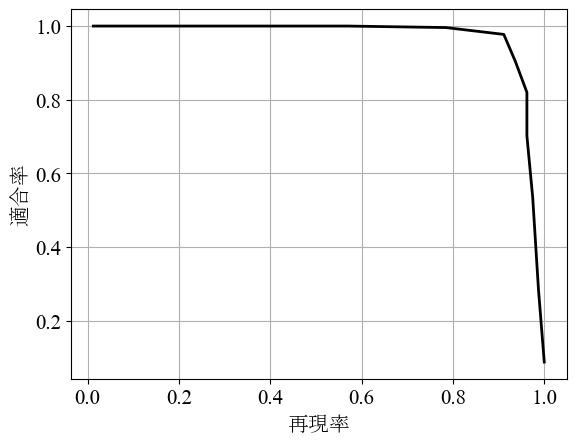

AUC：0.9576104751999227
理想の閾値：0.24
F値（最高）：0.9431961949297759
適合率（F値が最高の時）：0.977299880525687
再現率（F値が最高の時）：0.9113924050632911
C:\Users\Arakawa\AppData\Local\Temp\tmpcvd5n9lr\predict_results.png


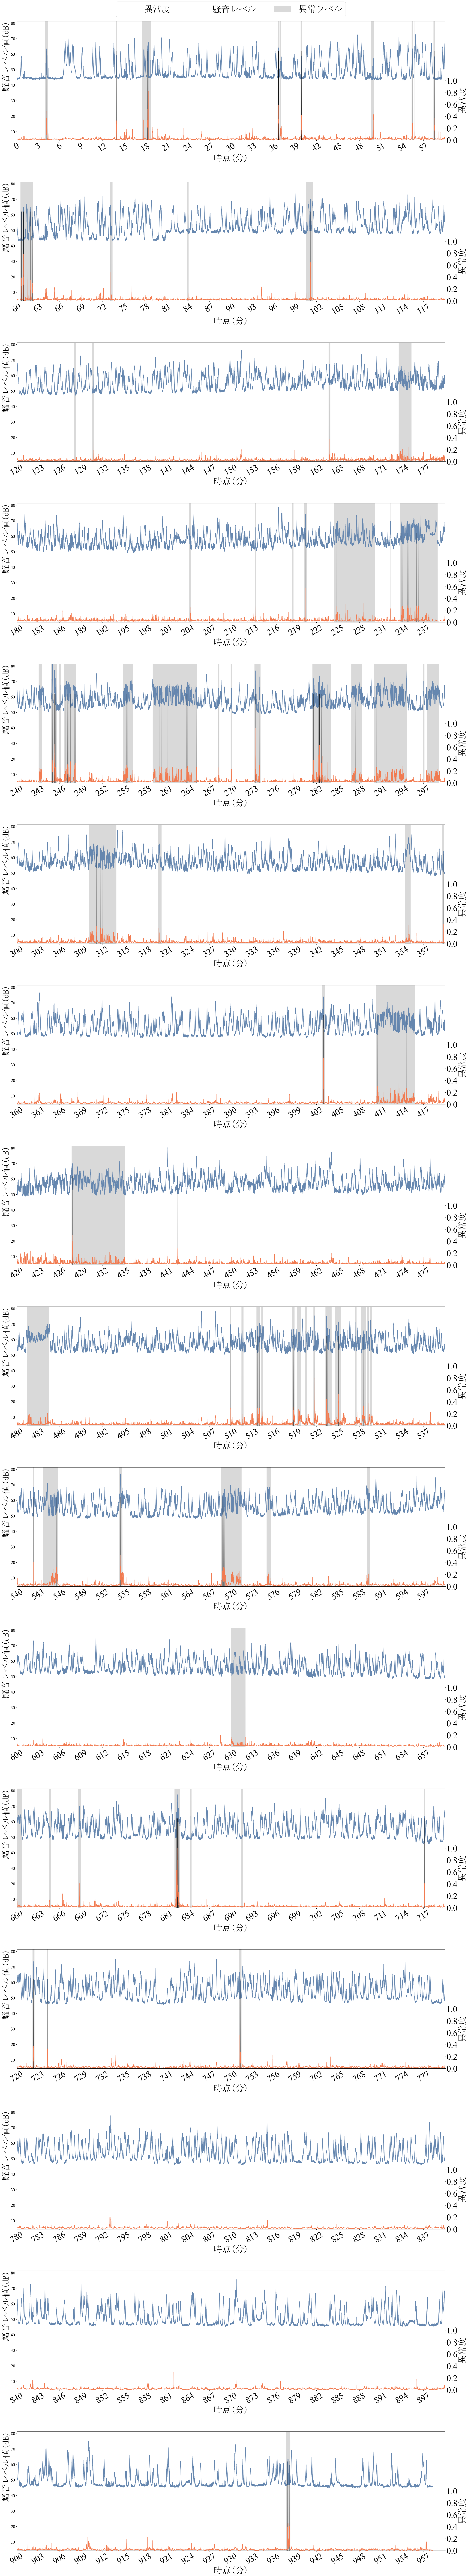

2024/01/05 18:33:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'knn' already exists. Creating a new version of this model...
Created version '5' of model 'knn'.


In [7]:
# remote_server_uri = "http://localhost:5000"  # set to your server URI
# mlflow.set_tracking_uri(remote_server_uri)

mlflow.autolog(log_models=False)

# 実験をアクティブ化(設定)する。ない場合は新たな実験を作成してアクティブ化する
mlflow.set_experiment("knn")
with mlflow.start_run():

    # テストデータとする日
    i=[1]
    label_train_day=[k for k in semi_train_day if k not in i]
    label_grant_day=i
    print(f'訓練データ：{label_train_day}')
    print(f'ラベル付与データ：{label_grant_day}日目')
    # Log the hyperparameters
    mlflow.log_params({'trainday':label_train_day, 'testday':label_grant_day})

    semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
    labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-4]].reset_index(drop=True)

    
    nk=best_params['nk']
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(semi_train_x)
    d = neigh.kneighbors(labeling_x)[0]
    d = np.mean(d, axis=1)

    semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'knnd']=d
    print('------------------------------------------------------')

    test_v=semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), ['original', 'label']].copy().reset_index(drop=True)
    d_test=(d-d.min())/(d.max()-d.min())

    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
    f_max=f_score.max()
    p_max=p_score[np.argmax(f_score)]
    r_max=r_score[np.argmax(f_score)]
    print('\033[31m'+f'AUC：{auc}'+'\033[0m')
    print(f'理想の閾値：{thr}')
    print(f'F値（最高）：{f_max}')
    print(f'適合率（F値が最高の時）：{p_max}')
    print(f'再現率（F値が最高の時）：{r_max}')
    
    # Log the loss metric
    mlflow.log_metric("test_AUC", auc)
    mlflow.log_metric("test_Fscore_best", f_max)
    mlflow.log_metric("test_Precision_when Fscore Best", p_max)
    mlflow.log_metric("test_Recall_when Fscore Best", r_max)
    
    # 一時ディレクトリに予測結果のグラフを保存して，mlflowに送信する
    with tempfile.TemporaryDirectory()  as tmp:
        filename = os.path.join(tmp, "predict_results.png")
        plot_timeseries([test_v['original'].values], test_v['label'].values, d=d_test, thr=thr, mlflow=filename)
        mlflow.log_artifact(filename, artifact_path="plot_timeseries")
       
    #     モデルの構造を定義しているソースコードを保存
    mlflow.log_artifact('knn_HO.ipynb', artifact_path="source_code") 
    # Log the model
    signature= infer_signature(labeling_x[:2], neigh.kneighbors(labeling_x[:2])[0])
    input_example= labeling_x[:2]
    mlflow.sklearn.log_model(
        neigh, 
        artifact_path="knn",
        signature=signature,
        registered_model_name="knn",
        input_example= input_example
    )

In [8]:
! mlflow ui --port 5001 

^C


## 異常度可視化

In [11]:
def figure_detail(df_test, d_test, start=0, stop=60):
    plt.rcParams["font.size"] = 22
    plt.rcParams["font.family"] = "Times New Roman"
    
    start_data=int(math.floor(start)*60/0.2)
    stop_data=int(math.ceil(stop)*60/0.2)

    test_plot=df_test['original'].values[start_data:stop_data]
    d=d_test[start_data:stop_data]
    label=df_test['label'].values[start_data:stop_data]*100
    label_index=range(len(label))
    time=[t*0.2/60 for t in range(start_data, stop_data)]
    fig, ax=plt.subplots(1, 1, figsize=(35, 7))
    ax.plot(time, test_plot, color='#6687AF' ,linewidth = 3, label='Noise Level')
    ax2=ax.twinx()
    ax2.plot(time, d, color='#F17B51',linewidth = 3, label='Anomaly Score')
    ax.fill_between(time, label,  facecolor='#D9D9D9', label='Abnormal period' )
    ax.set_xticks(np.arange(math.floor(start), math.ceil(stop), 5))
    ax.set_xticklabels(np.arange(math.floor(start), math.ceil(stop), 5), fontsize=50)
#     ax.xaxis.set_tick_params(rotation=30)
    ax.set_xlim(start, stop)
    ax.set_yticks(np.arange(40, 90, 10))
    ax.set_yticklabels(np.arange(40, 90, 10), fontsize=60)        
    ax.set_ylim(40, 80)
    ax2.set_yticks(np.arange(0, 12, 2)/10)
    ax2.set_yticklabels(np.arange(0, 12, 2)/10, fontsize=60)
    ax2.set_ylim(0, 1)
    ax.set_ylim(30, 80)
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h2+h1, l2+l1, loc='upper center', bbox_to_anchor=(.5, 1.4), ncol=3, prop={'family':"MS Mincho", 'size':60})
    ax.set_xlabel('Time(min)', fontfamily="MS Mincho",fontsize=60)
    ax.set_ylabel('Noise Level', fontfamily="MS Mincho",fontsize=60, loc='bottom')
    ax2.set_ylabel('Anomaly Score', fontfamily="MS Mincho",fontsize=60, loc='bottom')
#     plt.grid(True)
    plt.show()  

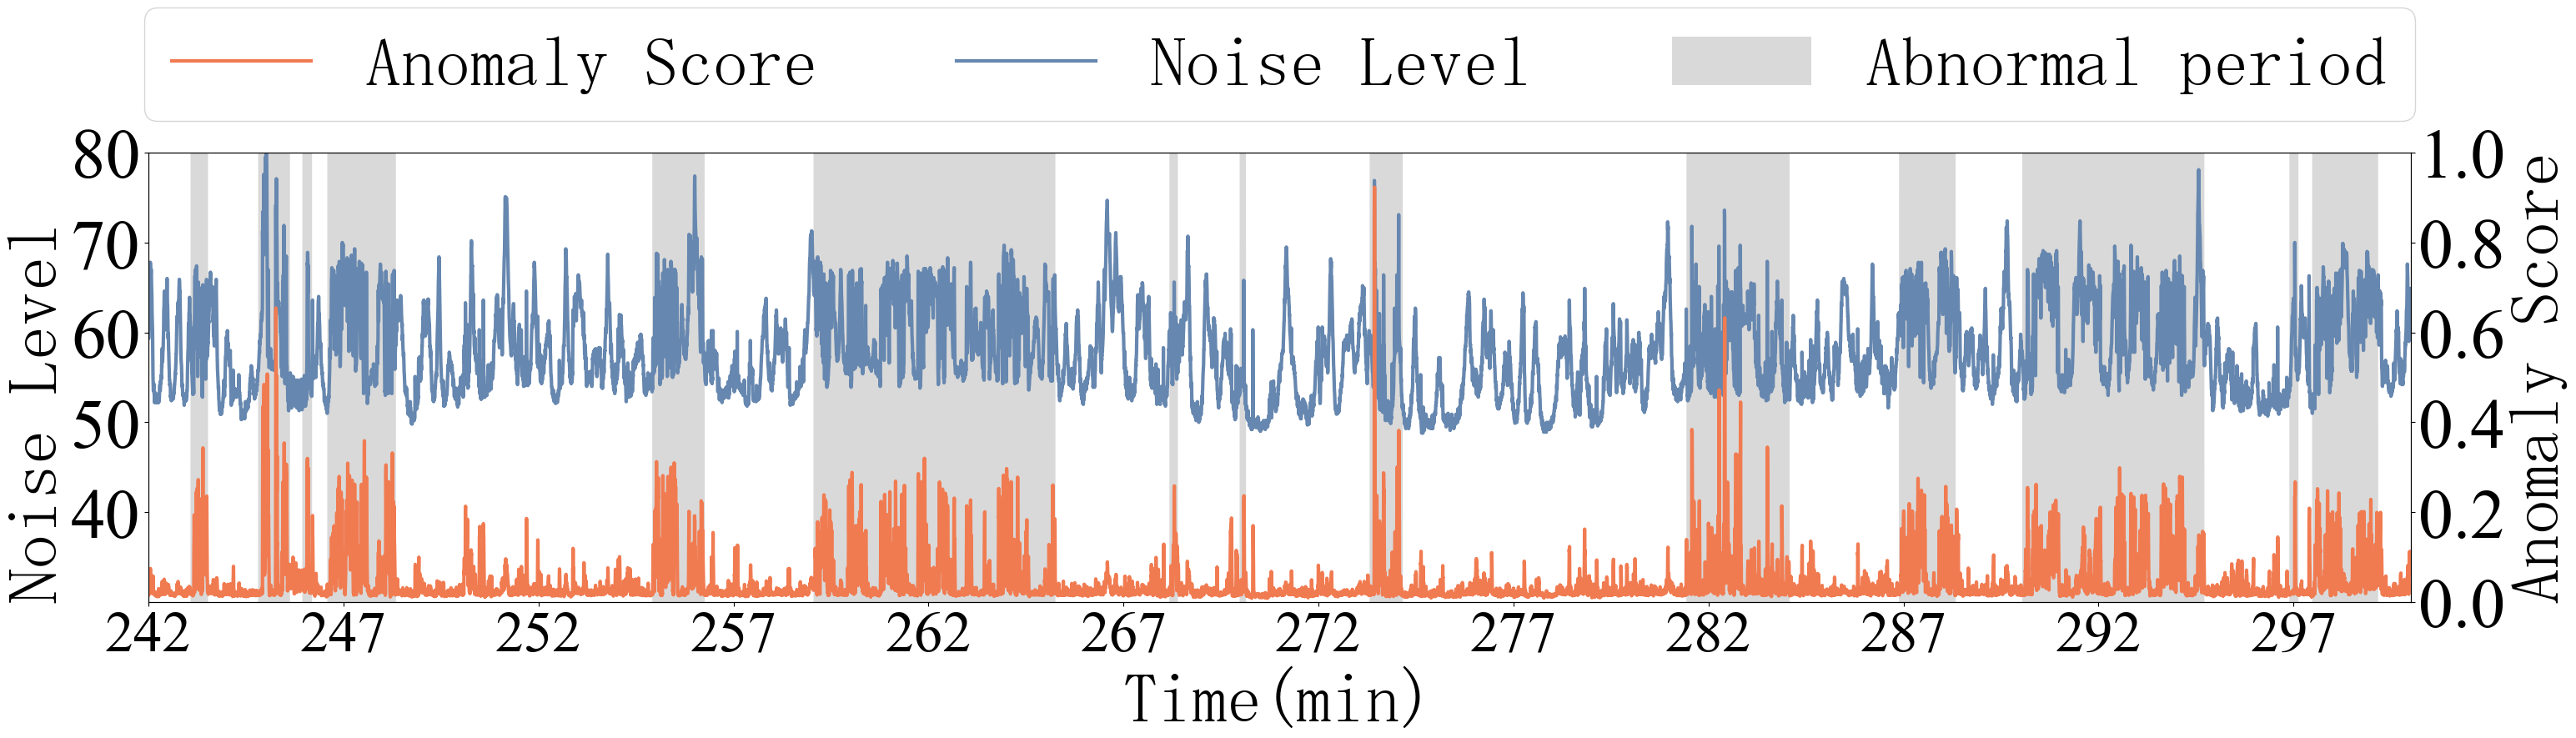

In [12]:
start=242
stop=300
figure_detail(test_v, d_test, start, stop)